
Water Hyacinth classification tool:
Copyright 2020 Niels Janssens

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

## 1. Install all required modules

In [1]:
# install required modules
!pip install pandas
!pip install geopandas
!pip install rasterio
!pip install sentinelhub
!pip install eo-learn
!pip install gdal
!pip install cartopy
!pip install shapely
!pip install fiona
!pip install geos
!pip install proj
!pip install scikit-image
!pip install geoviews
!apt-get install -qq libgdal-dev libproj-dev
!apt-get -qq install python-cartopy python3-cartopy
!pip install eo-learn-visualization[FULL]
!apt-get install python-numpy
!apt-get -qq install python-pyepsg python3-pyepsg

     |████████████████████████████████| 994 kB 5.2 MB/s 
     |████████████████████████████████| 15.4 MB 37 kB/s 
     |████████████████████████████████| 6.6 MB 65.4 MB/s 
     |████████████████████████████████| 19.3 MB 67 kB/s 
     |████████████████████████████████| 196 kB 5.3 MB/s 
     |████████████████████████████████| 131 kB 69.7 MB/s 
     |████████████████████████████████| 7.8 MB 68.6 MB/s 
     |████████████████████████████████| 123 kB 78.3 MB/s 
     |████████████████████████████████| 79 kB 7.8 MB/s 
     |████████████████████████████████| 127 kB 81.4 MB/s 
     |████████████████████████████████| 47 kB 4.6 MB/s 
  Created wheel for sentinelhub: filename=sentinelhub-3.3.2-py3-none-any.whl size=210768 sha256=3b9a07e238cd5e20c03e0b46e562a0d4f354462d79ff139bc9413370d56b1a6a
  Stored in directory: /root/.cache/pip/wheels/f9/f6/b3/86022511db328ed2e95f5aaa48fc8abab2b4b71b0a7922a9f5
  Created wheel for stringcase: filename=stringcase-1.2.0-py3-none-any.whl size=3587 sha256=8d29eb7a71

## 2. Import required models

In [2]:
# import required modules
# Built-in modules
import pickle
import os
import datetime
import itertools
from enum import Enum
from functools import partial
from datetime import timedelta
from datetime import datetime
import scipy.stats as stats
import copy

# Basics of Python data handling and visualization
import numpy as np
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import Polygon as Polygon1
from tqdm import tqdm_notebook as tqdm
import shapely
import pyepsg
from rasterio.plot import reshape_as_raster, reshape_as_image
from google.colab import drive

# Machine learning 
import lightgbm as lgb
import joblib
from sklearn.naive_bayes import GaussianNB 
import sklearn.model_selection
from sklearn import metrics
from sklearn import preprocessing

# Imports from eo-learn and sentinelhub-py
from sentinelhub import BBox, CRS, DataCollection, MimeType, SentinelHubRequest, SHConfig, BBoxSplitter, CustomUrlParam, DataSource, UtmZoneSplitter
from eolearn.core import SaveTask, LoadTask, FeatureType, LinearWorkflow, EOTask, OverwritePermission, EOExecutor, EOPatch
from eolearn.io import SentinelHubInputTask, SentinelHubDemTask, SentinelHubEvalscriptTask, get_available_timestamps, ExportToTiff
from eolearn.mask import AddValidDataMaskTask
from eolearn.geometry import VectorToRaster, PointSamplingTask, ErosionTask
from eolearn.features import LinearInterpolation, SimpleFilterTask
import eolearn.visualization
from skimage.filters import threshold_otsu, sobel
from skimage.morphology import disk, erosion, dilation, opening, closing, white_tophat

/usr/local/lib/python3.7/dist-packages/yaml/constructor.py:126: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if not isinstance(key, collections.Hashable):
/usr/local/lib/python3.7/dist-packages/tornado/httputil.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  class HTTPHeaders(collections.MutableMapping):
/usr/local/lib/python3.7/dist-packages/holoviews/operation/datashader.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Callable
/usr/local/lib/python3.7/dist-packages/jsonschema/compat.py:6: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is depre

## 3. Configure Sentinelhub settings & connect to Google Drive folder

In [3]:
"""insert sentinelhub configuration settings here. Create a Sentinel-2 configuration on 
   https://apps.sentinel-hub.com/dashboard/#/ and replace the empty "" instance_id, 
   sh_client_id and sh_client_secret by your custom strings"""

!sentinelhub.config --instance_id ""
!sentinelhub.config --sh_client_id ""
!sentinelhub.config --sh_client_secret ""
!sentinelhub.config --max_download_attempts 15
!sentinelhub.config --download_sleep_time 300
!sentinelhub.config --max_wfs_records_per_query 10
!sentinelhub.config --max_opensearch_records_per_query 10
!sentinelhub.config --show

The value of parameter 'max_download_attempts' was updated to 15
The value of parameter 'download_sleep_time' was updated to 300
The value of parameter 'max_wfs_records_per_query' was updated to 10
The value of parameter 'max_opensearch_records_per_query' was updated to 10
{
  "instance_id": "",
  "sh_client_id": "",
  "sh_client_secret": "",
  "sh_base_url": "https://services.sentinel-hub.com",
  "geopedia_wms_url": "https://service.geopedia.world",
  "geopedia_rest_url": "https://www.geopedia.world/rest",
  "aws_access_key_id": "",
  "aws_secret_access_key": "",
  "aws_metadata_url": "https://roda.sentinel-hub.com",
  "aws_s3_l1c_bucket": "sentinel-s2-l1c",
  "aws_s3_l2a_bucket": "sentinel-s2-l2a",
  "opensearch_url": "http://opensearch.sentinel-hub.com/resto/api/collections/Sentinel2",
  "max_wfs_records_per_query": 10,
  "max_opensearch_records_per_query": 10,
  "max_download_attempts": 15,
  "download_sleep_time": 300,
  "download_timeout_seconds": 120,
  "number_of_download_proce

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


## 4. Test and train manually labeled Water Hyacinth and Water for supervised classification pixels

In [6]:
%matplotlib inline

# read manually labeled pixel data that can be used as input for the Naive Bayes classifier
data = pd.read_csv('./drive/My Drive/WH_article/input_data/points_all.csv')
np.take(data,np.random.permutation(data.shape[0]),axis=0)

# split testing and training data using the sklearn module
testing_data, training_data = sklearn.model_selection.train_test_split(data)

# convert classes to an integer 
training_classes_int = np.zeros(training_data["Label"].values.shape, dtype=np.uint8) 
training_classes_int[training_data["Label"].values == "WH"] = 2 
training_classes_int[training_data["Label"].values == "W"] = 1

# convert classes to an integer 
testing_classes_int = np.zeros(testing_data["Label"].values.shape, dtype=np.uint8) 
testing_classes_int[testing_data["Label"].values == "WH"]   = 2 
testing_classes_int[testing_data["Label"].values == "W"] = 1 

# convert to one numpy array 
training_array = np.array([training_classes_int, training_data["ndvi"].values, training_data["fai"].values, 
                              training_data["B2"].values, training_data["B3"].values, training_data["B12"].values]) 

# flip around
training_array = training_array.transpose()

# convert to one numpy array 
testing_array = np.array([testing_classes_int, testing_data["ndvi"].values, testing_data["fai"].values, 
                             testing_data["B2"].values, testing_data["B3"].values, testing_data["B12"].values]) 

# flip around
testing_array = testing_array.transpose()

# train Gaussian Naive Bayes model 
gnb = GaussianNB() 
class_model = gnb.fit(training_array[:,1:], training_array[:,0]) 

# Check fit. Note as this uses exactly the same data as training doesn't represent accuracy.
# It does give a rough idea of how well model fits though
score = class_model.score(testing_array[:,1:], testing_array[:,0])
print("Classification fit using all data: {:.02}".format(score))


# predict classes by using the trained model
out_classes = class_model.predict(testing_array[:,1:])


# uncomment to save the model
joblib.dump(class_model, './model_SI_LULC.pkl')

Classification fit using all data: 0.98


['./model_SI_LULC.pkl']

In [10]:
# group data by Label, rename the bands for visualisation purposes
mean_values = data.groupby('Label', as_index=False)['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12'].mean()
std_values = data.groupby('Label', as_index=False)['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12'].std()
mean_values.rename(columns={'B1': '442', 'B2': '492', 'B3': '559', 'B4': '665', 'B5': '704', 'B6': '740', 'B7': '780', 'B8': '833', 'B8A': '864', 'B9': '944', 'B11': '1612', 'B12': '2190'}, inplace=True)
std_values.rename(columns={'B1': '442', 'B2': '492', 'B3': '559', 'B4': '665', 'B5': '704', 'B6': '740', 'B7': '780', 'B8': '833', 'B8A': '864', 'B9': '944', 'B11': '1612', 'B12': '2190'}, inplace=True)

# transpose data
mean_values = mean_values.transpose()
mean_values = mean_values.reset_index(drop=False)

# grab the first row for the header
new_header = mean_values.iloc[0] 

# take the data less the header row
mean_values = mean_values[1:] 

# set the header row as the df header
mean_values.columns = new_header 

# transpose data
std_values = std_values.transpose()
std_values = std_values.reset_index(drop=False)

# grab the first row for the header
new_header2 = std_values.iloc[0] 
new_header2

# take the data less the header row
std_values = std_values[1:] 
std_values.columns = new_header2

# calculate mean values for Water label
mean_values.W.values
mean_w = np.array(mean_values.W.values, dtype=float)

# calculate standard deviation values for Water label
std_values.W.values
st_w = np.array(std_values.W.values, dtype=float)

# calculate mean values for Water hyacinth label
mean_values.WH.values
mean_wh = np.array(mean_values.WH.values, dtype=float)

# calculate standard deviation values for Water hyacinth label
std_values.WH.values
st_wh = np.array(std_values.WH.values, dtype=float)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


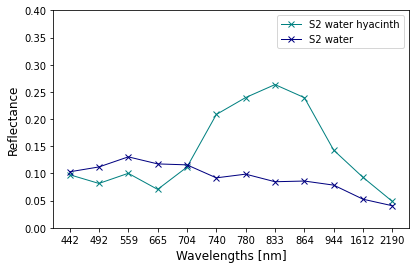

In [12]:
# create figure visualizing the mean spectral signatures of water and water hyacinth labeled pixels
# set figure subplots & size
fig, axes = plt.subplots(ncols = 2, figsize=(14,4))
axes[0].plot(test4.Label, test4.WH, c = 'teal', linewidth = 1, markerfacecolor = 'teal', marker = 'x',markersize = 6)
axes[0].plot(test4.Label, test4.W, c = 'navy', linewidth = 1, markerfacecolor = 'navy', marker = 'x',markersize = 6)
axes[0].legend(['S2 water hyacinth', 'S2 water'], ncol=1, fontsize = 10)
axes[0].set_xlabel("Wavelengths [nm]", fontsize = 12)
axes[0].set_ylabel("Reflectance", fontsize = 12)
axes[0].set_ylim(0,0.4)
axes[1].set_visible(False)

# save figure to specified folder and plot figure
plt.savefig('./drive/My Drive/WH_article/figures/spectral_signatures.png', bbox_inches = "tight")
plt.show()

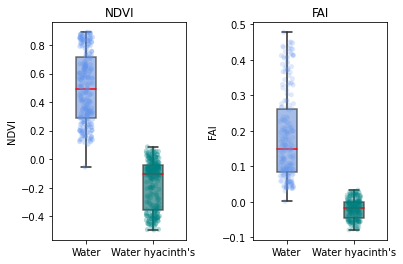

In [13]:
# create figure visualizing the spectral signatures of water and water hyacinth labeled pixels
# set figure subplots & size
f, axes = plt.subplots(1, 2)
sns.set_style("ticks")

#create your own color array
my_colors = ["cornflowerblue", "teal"]
my_colors1 = ["cornflowerblue", "teal"]

# add color array to set_palette
sns.set_palette(my_colors)

# add boxplot of ndvi data       
sns.boxplot(x="Label", y="ndvi",              
data=testing_data, width=0.3, boxprops=dict(alpha=.65), medianprops=dict(color="red", alpha=1), ax=axes[0])

# add stripplot of ndvi data
sns.stripplot(x="Label", y="ndvi",              
data=testing_data, alpha=0.3, palette = my_colors1, ax=axes[0])

# set ndvi labels
axes[0].set(xticklabels=["Water", "Water hyacinth's"])
axes[0].set_title('NDVI')
axes[0].set_ylabel('NDVI')
axes[0].set_xlabel('')
 
# add boxplot of fai data        
ax = sns.boxplot(x="Label", y="fai",              
data=testing_data, width=0.3, boxprops=dict(alpha=.65), medianprops=dict(color="red", alpha=1), ax=axes[1])

# add stripplot of fai data
ax = sns.stripplot(x="Label", y="fai",              
data=testing_data, alpha=0.2, palette = my_colors1, ax=axes[1])

# set fai labels
axes[1].set(xticklabels=["Water", "Water hyacinth's"])
axes[1].set_title('FAI')
axes[1].set_ylabel('FAI')
axes[1].set_xlabel('')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.8)

# save figure to specified folder and plot figure
plt.savefig('./drive/My Drive/WH_article/figures/spectral_signatures_fai.png', bbox_inches = "tight")

## 5. Define area of interest
Load shapefile and create bounding boxes for parallel computing

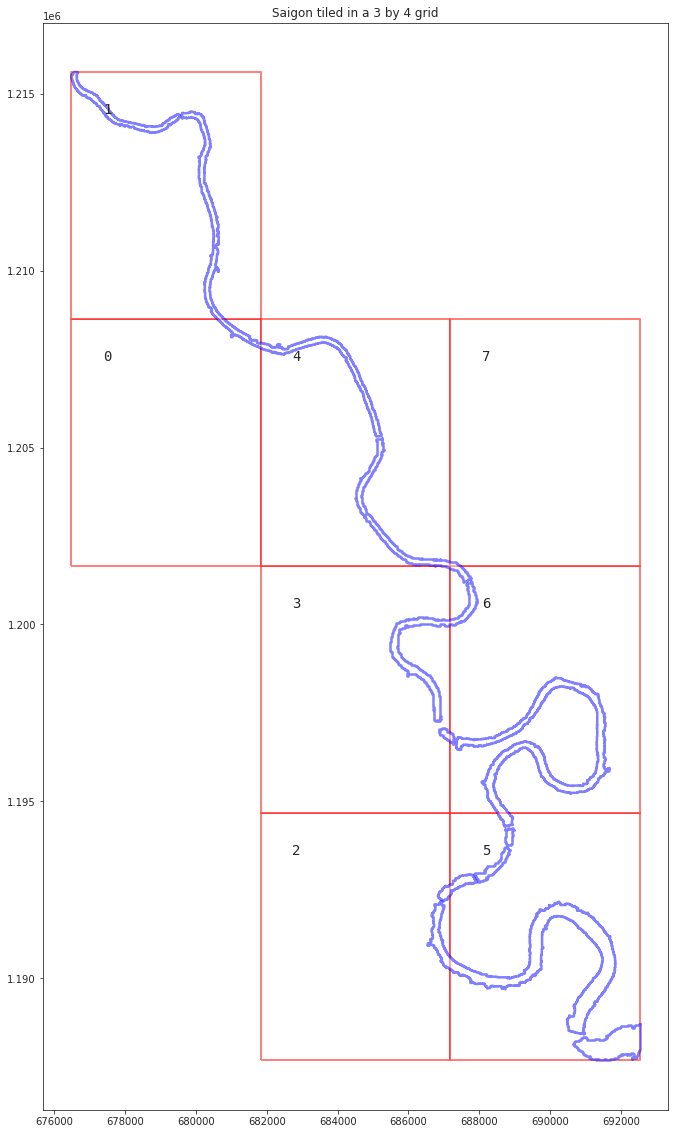

In [21]:
# load geojson file, file can be found on github page
river = GeoDataFrame.from_file(os.path.join('./drive/My Drive/WH_article/input_data/water_extent_v3_clipped.geojson'))

# convert CRS to UTM_48N, based on our area of interest
river = river.to_crs(crs=CRS.UTM_48N.pyproj_crs())

# get the country's shape in polygon format & create a bounding box
river_shape = river.geometry.tolist()[-1]
minx, miny, maxx, maxy = river_shape.bounds
river_bbox = BBox([minx, miny, maxx, maxy], crs=CRS.UTM_48N.pyproj_crs())
river_bbox = river_bbox.geometry - river_shape 

# split river into multiple smaller bounding boxes
bbox_splitter = BBoxSplitter([river_shape], CRS.UTM_48N.pyproj_crs(), (3,4))
bbox_list = np.array(bbox_splitter.get_bbox_list())
info_list = np.array(bbox_splitter.get_info_list())

# create patchIDs that can be used for parallel computing
patchIDs = []
for idx, [bbox, info] in enumerate(zip(bbox_list, info_list)):
    patchIDs.append(idx)
    
# prepare info of selected EOPatches
geometry = [Polygon1(bbox.get_polygon()) for bbox in bbox_list[patchIDs]]
idxs_x = [info['index_x'] for info in info_list[patchIDs]]
idxs_y = [info['index_y'] for info in info_list[patchIDs]]

# create geodataframe using the idxs_x and idxs_y
gdf = gpd.GeoDataFrame({'index_x': idxs_x, 'index_y': idxs_y}, 
                       crs=CRS.UTM_48N.pyproj_crs(), 
                       geometry=geometry)


# create polygon and set fontdict that can be used for figure
poly = gdf['geometry'][0]
x1, y1, x2, y2 = poly.bounds
aspect_ratio = (y1 - y2) / (x1 - x2)
fontdict = {'family': 'monospace', 'weight': 'normal', 'size': 14}

# if bboxes have all same size, estimate offset
xl, yl, xu, yu = gdf.geometry[0].bounds
xoff, yoff = (xu-xl)/3, (yu-yl)/3

# figure with bboxes and river shapefile plotted
fig, ax = plt.subplots(figsize=(20,20))
gdf.plot(ax=ax, facecolor='w', edgecolor='r', alpha=0.5, linewidth=2)
river.plot(ax=ax, facecolor='w', edgecolor='b', alpha=0.5, linewidth=2.5)
ax.set_title('River tiled in a 3 by 4 grid');

# add annotiation text figure
for idx in gdf.index:
    eop_name = '{0}x{1}'.format(gdf.index_x[idx], gdf.index_y[idx])
    centroid, = list(gdf.geometry[idx].centroid.coords)
    ax.text(centroid[0]-xoff, centroid[1]+yoff, '{}'.format(idx), fontdict=fontdict)

# save figure to specified folder and plot figure
plt.savefig('./drive/My Drive/WH_article/figures/area_of_interest_bboxes.jpg') 

## 6. Create EO workflow to:
*   Download data
*   Create a cloud mask
*   Create a river mask
*   Add FAI, NDVI
*   Add spatial temporal features
*   Perform Naive bayes classification

In [22]:
#adapt time_interval according to period of interest
time_interval = ['2020-03-01', '2020-03-01'] # time interval for the SH request

In [23]:
# create nominal water mask that can be used to extract pixel values that are actually located within the river boundaries
add_nominal_water = VectorToRaster(river, (FeatureType.MASK_TIMELESS, 'NOMINAL_WATER'), values=1,
                                   raster_shape=(FeatureType.MASK, 'IS_DATA'), raster_dtype=np.uint8)

### 6.1 EO Tasks to compute 'VALIDE_DATA' based on cloud masks and count the valid observations

In [25]:
class SentinelHubValidData:
    """
    Combine Sen2Cor's classification map with `IS_DATA` to define a `VALID_DATA_SH` mask
    The SentinelHub's cloud mask is asumed to be found in eopatch.mask['CLM']
    """
    def __call__(self, eopatch):
        return np.logical_and(eopatch.mask['IS_DATA'].astype(np.bool),
                              np.logical_not(eopatch.mask['CLM'].astype(np.bool)))

class CountValid(EOTask):
    """
    The task counts number of valid observations in time-series and stores the results in the timeless mask.
    """
    def __init__(self, count_what, feature_name):
        self.what = count_what
        self.name = feature_name

    def execute(self, eopatch):
        eopatch.add_feature(FeatureType.MASK_TIMELESS, self.name, np.count_nonzero(eopatch.mask[self.what],axis=0))

        return eopatch

### 6.2 Create workflow and required classes

In [29]:
# add a request for B(B02), G(B03), R(B04), NIR (B08), SWIR1(B11), SWIR2(B12) 
# from default layer 'ALL_BANDS' at 10m resolution
# Here we also do a simple filter of cloudy scenes. A detailed cloud cover 
# detection is performed in the next step

# use sentinelhubinputtask function that retrieves the specified data for our area of interest
custom_script = ['B02', 'B03', 'B04', 'B06', 'B08', 'B11', 'B12']
add_data = SentinelHubInputTask(
    bands_feature=(FeatureType.DATA, 'BANDS'),
    bands = custom_script,
    resolution=10,
    maxcc=0.8,
    data_source=DataSource.SENTINEL2_L2A,
    additional_data=[(FeatureType.MASK, 'dataMask', 'IS_DATA'),
                     (FeatureType.MASK, 'CLM'),
                     (FeatureType.DATA, 'CLP'),
                     (FeatureType.MASK, 'SCL')])


# class that defines if valid data fraction is above the specified threshold
class ValidDataFractionPredicate:
    """ Predicate that defines if a frame from EOPatch's time-series is valid or not. Frame is valid, if the 
    valid data fraction is above the specified threshold.
    """
    def __init__(self, threshold):
        self.threshold = threshold
        
    def __call__(self, array):
        coverage = np.sum(array.astype(np.uint8)) / np.prod(array.shape)
        return coverage > self.threshold
                     
# class that calculates ndvi on a pixel level
class NormalizedDifferenceIndex(EOTask):   

    def __init__(self, feature_name, band_a, band_b):
        self.feature_name = feature_name
        self.band_a_fetaure_name = band_a.split('/')[0]
        self.band_b_fetaure_name = band_b.split('/')[0]
        self.band_a_fetaure_idx = int(band_a.split('/')[-1])
        self.band_b_fetaure_idx = int(band_b.split('/')[-1])
        
    def execute(self, eopatch):
        band_a = eopatch.data[self.band_a_fetaure_name][..., self.band_a_fetaure_idx]
        band_b = eopatch.data[self.band_b_fetaure_name][..., self.band_b_fetaure_idx]
        
        ndvi = (band_a - band_b) / (band_a  + band_b)
        
        eopatch.add_feature(FeatureType.DATA, self.feature_name, ndvi[..., np.newaxis])
        
        return eopatch

# class that calculates fai on a pixel level
class FloatingAlgaeIndex(EOTask):

    def __init__(self, feature_name, band_a, band_b, band_c, band_d, band_e, band_f, band_g):
        self.feature_name = feature_name
        self.band_a_fetaure_name = band_a.split('/')[0]
        self.band_b_fetaure_name = band_b.split('/')[0]
        self.band_c_fetaure_name = band_c.split('/')[0]
        self.band_d_fetaure_name = band_d.split('/')[0]
        self.band_e_fetaure_name = band_e.split('/')[0]
        self.band_f_fetaure_name = band_f.split('/')[0]
        self.band_g_fetaure_name = band_g.split('/')[0]
        self.band_a_fetaure_idx = int(band_a.split('/')[-1])
        self.band_b_fetaure_idx = int(band_b.split('/')[-1])
        self.band_c_fetaure_idx = int(band_c.split('/')[-1])
        self.band_d_fetaure_idx = int(band_d.split('/')[-1])
        self.band_e_fetaure_idx = int(band_e.split('/')[-1])
        self.band_f_fetaure_idx = int(band_f.split('/')[-1])
        self.band_g_fetaure_idx = int(band_g.split('/')[-1])
        
    def execute(self, eopatch):
        band_a = eopatch.data[self.band_a_fetaure_name][..., self.band_a_fetaure_idx]
        band_b = eopatch.data[self.band_b_fetaure_name][..., self.band_b_fetaure_idx]
        band_c = eopatch.data[self.band_c_fetaure_name][..., self.band_c_fetaure_idx]
        band_d = eopatch.data[self.band_d_fetaure_name][..., self.band_d_fetaure_idx]
        band_e = eopatch.data[self.band_e_fetaure_name][..., self.band_e_fetaure_idx]
        band_f = eopatch.data[self.band_f_fetaure_name][..., self.band_f_fetaure_idx]
        band_g = eopatch.data[self.band_g_fetaure_name][..., self.band_g_fetaure_idx]
        

        fai = band_e - (((band_c * (842-1610)) + (band_g * (665-842)))/(665-1614))  
        
        eopatch.add_feature(FeatureType.DATA, self.feature_name, fai[..., np.newaxis])
        
        return eopatch

# class that uses all the required input values on a pixel level and classifies WH & W using the trained Naive Bayes model
class WaterhyacinthClassification(EOTask):

    def __init__(self, feature_name, band_a, band_b, band_c, band_d, band_e, band_f, band_g):
        self.feature_name = feature_name
        self.band_a_fetaure_name = band_a.split('/')[0]
        self.band_b_fetaure_name = band_b.split('/')[0]
        self.band_c_fetaure_name = band_c.split('/')[0]
        self.band_d_fetaure_name = band_d.split('/')[0]
        self.band_e_fetaure_name = band_e.split('/')[0]
        self.band_f_fetaure_name = band_f.split('/')[0]
        self.band_g_fetaure_name = band_g.split('/')[0]
        self.band_a_fetaure_idx = int(band_a.split('/')[-1])
        self.band_b_fetaure_idx = int(band_b.split('/')[-1])
        self.band_c_fetaure_idx = int(band_c.split('/')[-1])
        self.band_d_fetaure_idx = int(band_d.split('/')[-1])
        self.band_e_fetaure_idx = int(band_e.split('/')[-1])
        self.band_f_fetaure_idx = int(band_f.split('/')[-1])
        self.band_g_fetaure_idx = int(band_g.split('/')[-1])
        
    def execute(self, eopatch):
        band_a = eopatch.data[self.band_a_fetaure_name][..., self.band_a_fetaure_idx]
        band_b = eopatch.data[self.band_b_fetaure_name][..., self.band_b_fetaure_idx]
        band_c = eopatch.data[self.band_c_fetaure_name][..., self.band_c_fetaure_idx]
        band_d = eopatch.data[self.band_d_fetaure_name][..., self.band_d_fetaure_idx]
        band_e = eopatch.data[self.band_e_fetaure_name][..., self.band_e_fetaure_idx]
        band_f = eopatch.data[self.band_f_fetaure_name][..., self.band_f_fetaure_idx]
        band_g = eopatch.data[self.band_g_fetaure_name][..., self.band_g_fetaure_idx]

        fai = eopatch.data['FAI']
        ndvi = eopatch.data['NDVI']
        band_c = eopatch.data['BANDS'][..., [2]]
        band_e = eopatch.data['BANDS'][..., [4]]
        band_f = eopatch.data['BANDS'][..., [6]]

        img = np.concatenate((ndvi, fai, band_c, band_e, band_f),axis=-1)
        img = np.nan_to_num(img)

        class_prediction = class_model.predict(img.reshape(-1, 5))

        # reshape our classification map back into a 2D matrix so we can visualize it
        class_prediction = class_prediction.reshape(img[:, :, :, 0].shape)

        eopatch.add_feature(FeatureType.DATA, self.feature_name, class_prediction[..., np.newaxis])
        
        return eopatch
  
# tasks for calculating new features
ndvi = NormalizedDifferenceIndex('NDVI', 'BANDS/4', 'BANDS/2')
ndwi = NormalizedDifferenceIndex('NDWI', 'BANDS/1', 'BANDS/3')
plastic = NormalizedDifferenceIndex('PLASTIC', 'BANDS/4', 'BANDS/0')
fai = FloatingAlgaeIndex('FAI', 'BANDS/0', 'BANDS/1', 'BANDS/2', 'BANDS/3', 'BANDS/4', 'BANDS/5', 'BANDS/6')
whc = WaterhyacinthClassification('WHC', 'BANDS/0', 'BANDS/1', 'BANDS/2', 'BANDS/3', 'BANDS/4', 'BANDS/5', 'BANDS/6')

# calculate ratio of coverage
def calculate_coverage(array):
    return 1.0 - np.count_nonzero(array) / np.size(array)

# add validdatacoverage as layer within the EOpatch
class AddValidDataCoverage(EOTask):

    def execute(self, eopatch):

        valid_data = eopatch.get_feature(FeatureType.MASK, 'IS_VALID')
        time, height, width, channels = valid_data.shape

        coverage = np.apply_along_axis(calculate_coverage, 1,
                                       valid_data.reshape((time, height * width * channels)))

        eopatch.add_feature(FeatureType.SCALAR, 'COVERAGE', coverage[:, np.newaxis])
        return eopatch

add_coverage = AddValidDataCoverage()

# TASK FOR VALID MASK
# validate pixels using SentinelHub's cloud detection mask and region of acquisition
add_sh_valmask = AddValidDataMaskTask(SentinelHubValidData(),
                                      'IS_VALID' # name of output mask
                                     )

# TASK FOR COUNTING VALID PIXELS
# count number of valid observations per pixel using valid data mask
count_val_sh = CountValid('IS_VALID', # name of existing mask
                          'VALID_COUNT' # name of output scalar
                         )

# TASK FOR FILTERING OUT TOO CLOUDY SCENES
# keep frames with > 80 % valid coverage
valid_data_predicate = ValidDataFractionPredicate(0.01)
filter_task = SimpleFilterTask((FeatureType.MASK, 'IS_VALID'), valid_data_predicate)

# TASK FOR SAVING TO OUTPUT (if needed & only do this when there is no data yet)
path_out = './drive/My Drive/WH_article/output_folder/eopatches_1/'
if not os.path.isdir(path_out):
    os.makedirs(path_out)
save = SaveTask(path_out, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

/usr/local/lib/python3.7/dist-packages/sentinelhub/data_collections.py:694: SHDeprecationWarning: Parameter data_source is deprecated, use data_collection instead
  category=SHDeprecationWarning)


### 6.3 Define the workflow

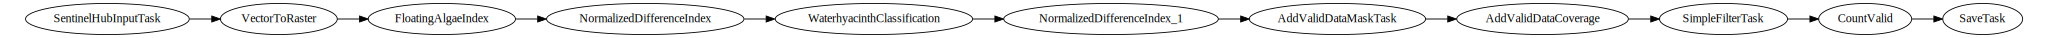

In [32]:
# define wokflow using above specified classes and visualize graph 
workflow = LinearWorkflow(add_data, add_nominal_water, fai, ndvi, whc, plastic, add_sh_valmask, add_coverage, filter_task, count_val_sh, save)
workflow.dependency_graph('graph.png')

### 6.4 Execute the workflow for each patch

In [ ]:
%%time

# Execute the workflow
# define additional parameters of the workflow
execution_args = []
for idx, bbox in enumerate(bbox_list[patchIDs]):
    execution_args.append({
        add_data:{'bbox': bbox, 'time_interval': time_interval},
        save: {'eopatch_folder': 'eopatch_{}'.format(idx)}
    })
    
executor = EOExecutor(workflow, execution_args, save_logs=True)
executor.run(workers=3, multiprocess=True)

executor.make_report()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide



CPU times: user 236 ms, sys: 246 ms, total: 482 ms
Wall time: 17.2 s


### 6.5 Loop to create a list with dates in which each patch contains the same dates

In [33]:
# lazy load all eopatches
eop_locations = []
eop_locations = [f'./drive/My Drive/WH_article/output_folder/eopatches/eopatch_0', f'./drive/My Drive/WH_article/output_folder/eopatches/eopatch_1', f'./drive/My Drive/WH_article/output_folder/eopatches/eopatch_2', f'./drive/My Drive/WH_article/output_folder/eopatches/eopatch_3', f'./drive/My Drive/WH_article/output_folder/eopatches/eopatch_4', f'./drive/My Drive/WH_article/output_folder/eopatches/eopatch_5', f'./drive/My Drive/WH_article/output_folder/eopatches/eopatch_6', f'./drive/My Drive/WH_article/output_folder/eopatches/eopatch_7']
eopatches = []
for loc in eop_locations:
    eop = EOPatch.load(loc, lazy_loading = True)
    eopatches.append(eop)

# create sets of dates
sets = [set([ts for ts in eop.timestamp]) for eop in eopatches]

# loop through eop timestamps, keep only intersections
dt_list = sets[0]
for i in range(1,len(sets)):
    dt_list = dt_list.intersection(sets[i])

# convert to array, sort
dt_list = np.array(list(dt_list))
dt_list = np.sort(dt_list)
list1 = dt_list.tolist()

date_list = [date_obj.strftime('%m/%d/%Y') for date_obj in list1]

KeyboardInterrupt: ignored

In [ ]:
# lazy load upper area
eop_locations = []
eop_locations = [f'./drive/My Drive/WH_article/output_folder/eopatches/eopatch_0', f'./drive/My Drive/WH_article/output_folder/eopatches/eopatch_1', f'./drive/My Drive/WH_article/output_folder/eopatches/eopatch_4']
eopatches = []
for loc in eop_locations:
    eop = EOPatch.load(loc, lazy_loading = True)
    eopatches.append(eop)

# create sets of dates
sets = [set([ts for ts in eop.timestamp]) for eop in eopatches]

# loop through eop timestamps, keep only intersections
dt_list = sets[0]
for i in range(1,len(sets)):
    dt_list = dt_list.intersection(sets[i])

# convert to array, sort
dt_list = np.array(list(dt_list))
dt_list = np.sort(dt_list)
list1 = dt_list.tolist()

date_list_1 = [date_obj.strftime('%m/%d/%Y') for date_obj in list1]

In [ ]:
# lazy load all middle area
eop_locations = []
eop_locations = [f'./drive/My Drive/WH_article/output_folder/eopatches/eopatch_7', f'./drive/My Drive/WH_article/output_folder/eopatches/eopatch_3', f'./drive/My Drive/WH_article/output_folder/eopatches/eopatch_6']
eopatches = []
for loc in eop_locations:
    eop = EOPatch.load(loc, lazy_loading = True)
    eopatches.append(eop)

# create sets of dates
sets = [set([ts for ts in eop.timestamp]) for eop in eopatches]

# loop through eop timestamps, keep only intersections
dt_list = sets[0]
for i in range(1,len(sets)):
    dt_list = dt_list.intersection(sets[i])

# convert to array, sort
dt_list = np.array(list(dt_list))
dt_list = np.sort(dt_list)
list1 = dt_list.tolist()

date_list_2 = [date_obj.strftime('%m/%d/%Y') for date_obj in list1]

In [ ]:
# lazy load lower area
eop_locations = []
eop_locations = [f'./drive/My Drive/WH_article/output_folder/eopatches/eopatch_2', f'./drive/My Drive/WH_article/output_folder/eopatches/eopatch_5']
eopatches = []
for loc in eop_locations:
    eop = EOPatch.load(loc, lazy_loading = True)
    eopatches.append(eop)

# create sets of dates
sets = [set([ts for ts in eop.timestamp]) for eop in eopatches]

# loop through eop timestamps, keep only intersections
dt_list = sets[0]
for i in range(1,len(sets)):
    dt_list = dt_list.intersection(sets[i])

# convert to array, sort
dt_list = np.array(list(dt_list))
dt_list = np.sort(dt_list)
list1 = dt_list.tolist()

date_list_3 = [date_obj.strftime('%m/%d/%Y') for date_obj in list1]

### 6.6 Cloud masking system to create masks based on 10m resolution

In [ ]:
path_out = './drive/My Drive/WH_article/output_folder/eopatches'
# TASK TO LOAD EXISTING EOPATCHES
load = LoadTask(path_out, lazy_loading = True)

# set path to output folder and create a save function for the workflow
path_out_sampled = './drive/My Drive/WH_article/output_folder/eopatches_sampled'
if not os.path.isdir(path_out_sampled):
    os.makedirs(path_out_sampled)
save = SaveTask(path_out_sampled, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

# create a list of dates that can be used as filter to exclude images that do not overlap area of interest completely
def dt_list_filter(date, date_list, tolerance):
    return np.min(np.abs(date - np.array(date_list))) <= tolerance

# class that performs cloud masking
class cloud_mask(EOTask):

    def __init__(self, feature_name):
      self.feature_name = feature_name
        
    def execute(self, eopatch):
      # mask of valid CLM values (0 = no cloud, 1 = cloud, 2 = no data)
      valid_clm = eop.mask['CLM'] == 1

      # mask of valid SCL values (4 = vegetation, 5 = baresoil, 6 = water)
      valid_scl = (eop.mask['SCL'] == 4) | (eop.mask['SCL'] == 5) | (eop.mask['SCL'] == 6)

      # merge valid masks together (i.e. only where both are valid)
      valid_mask = valid_clm  | valid_scl

      eopatch.add_feature(FeatureType.MASK, self.feature_name, valid_mask)
      return eopatch

# create 'VALID_MASK' feature
cloud_mask2 = cloud_mask('VALID_MASK')

# create filter_task2 feature that makes use of the class SimpleFilterTask
filter_task2 = SimpleFilterTask(feature=FeatureType.TIMESTAMP, 
                         filter_func=partial(dt_list_filter, date_list=dt_list, tolerance=timedelta(days=0))) 

### 6.7 Define the workflow #2

In [ ]:
# Define the workflow #2
workflow = LinearWorkflow(
    load,
    filter_task2,
    cloud_mask2,
    save
)

### 6.8 Execute the workflow for each patch #2
In this workflow we are filtering the images in order to exclude cloudy pixels and images that do not completely cover the area of interest

In [ ]:
%%time
   
execution_args = []
for idx in range(8):
    execution_args.append({
        load: {'eopatch_folder': f'eopatch_{idx}'},
        save: {'eopatch_folder': f'eopatch_{idx}'}
    })
    
executor = EOExecutor(workflow, execution_args, save_logs=True)
executor.run(workers=1, multiprocess=False)

executor.make_report()

KeyboardInterrupt: ignored

### 6.9 Lazy load eopatches, extract values and insert them into a list

In [ ]:
# lazy load all eopatches
eop_locations = []
eop_locations = [f'./drive/My Drive/WH_article/output_folder/eopatches_sampled/eopatch_0', f'./drive/My Drive/WH_article/output_folder/eopatches_sampled/eopatch_1', f'./drive/My Drive/WH_article/output_folder/eopatches_sampled/eopatch_2', f'./drive/My Drive/WH_article/output_folder/eopatches_sampled/eopatch_3', f'./drive/My Drive/WH_article/output_folder/eopatches_sampled/eopatch_4', f'./drive/My Drive/WH_article/output_folder/eopatches_sampled/eopatch_5', f'./drive/My Drive/WH_article/output_folder/eopatches_sampled/eopatch_6', f'./drive/My Drive/WH_article/output_folder/eopatches_sampled/eopatch_7']
eopatches = []
for loc in eop_locations:
    eop = EOPatch.load(loc, lazy_loading = True)
    eopatches.append(eop)

# create sets of dates
sets = [set([ts for ts in eop.timestamp]) for eop in eopatches]

# loop through eop timestamps, keep only intersections
dt_list = sets[0]
for i in range(1,len(sets)):
    dt_list = dt_list.intersection(sets[i])

# convert to array, sort
dt_list = np.array(list(dt_list))
dt_list = np.sort(dt_list)
list1 = dt_list.tolist()

# create a list of all water hyacinth values & dates for each year for all eopatches
date_list_sampled = [date_obj.strftime('%m/%d/%Y') for date_obj in list1]
date_list_sampled_2018 = date_list_sampled[0:50]
date_list_sampled_2019 = date_list_sampled[51:100]
date_list_sampled_2020 = date_list_sampled[101:]

In [ ]:
# lazy load upper area (0,1,4)
eop_locations = []
eop_locations = [f'./drive/My Drive/WH_article/output_folder/eopatches_sampled/eopatch_0', f'./drive/My Drive/WH_article/output_folder/eopatches_sampled/eopatch_1', f'./drive/My Drive/WH_article/output_folder/eopatches_sampled/eopatch_4']
eopatches = []
for loc in eop_locations:
    eop = EOPatch.load(loc, lazy_loading = True)
    eopatches.append(eop)

# create sets of dates
sets = [set([ts for ts in eop.timestamp]) for eop in eopatches]

# loop through eop timestamps, keep only intersections
dt_list = sets[0]
for i in range(1,len(sets)):
    dt_list = dt_list.intersection(sets[i])

# convert to array, sort
dt_list = np.array(list(dt_list))
dt_list = np.sort(dt_list)
list1 = dt_list.tolist()

# create a list of all water hyacinth values & dates for each year based on upstream boxes (0,1,4)
date_list_sampled_1 = [date_obj.strftime('%m/%d/%Y') for date_obj in list1]
date_list_sampled_1_2018 = date_list_sampled_1[0:50]
date_list_sampled_1_2019 = date_list_sampled_1[51:100]
date_list_sampled_1_2020 = date_list_sampled_1[101:]

In [ ]:
# lazy load all midstream area (7,3,6)
eop_locations = []
eop_locations = [f'./drive/My Drive/WH_article/output_folder/eopatches_sampled/eopatch_7', f'./drive/My Drive/WH_article/output_folder/eopatches_sampled/eopatch_3', f'./drive/My Drive/WH_article/output_folder/eopatches_sampled/eopatch_6']
eopatches = []
for loc in eop_locations:
    eop = EOPatch.load(loc, lazy_loading = True)
    eopatches.append(eop)

# create sets of dates
sets = [set([ts for ts in eop.timestamp]) for eop in eopatches]

# loop through eop timestamps, keep only intersections
dt_list = sets[0]
for i in range(1,len(sets)):
    dt_list = dt_list.intersection(sets[i])

# convert to array, sort
dt_list = np.array(list(dt_list))
dt_list = np.sort(dt_list)
list1 = dt_list.tolist()

# create a list of all water hyacinth values & dates for each year based on midstream boxes (7,3,6)
date_list_sampled_2 = [date_obj.strftime('%m/%d/%Y') for date_obj in list1]
date_list_sampled_2_2018 = date_list_sampled_2[0:50]
date_list_sampled_2_2019 = date_list_sampled_2[51:100]
date_list_sampled_2_2020 = date_list_sampled_2[101:]

In [ ]:
# lazy load downstream area (2,5)
eop_locations = []
eop_locations = [f'./drive/My Drive/WH_article/output_folder/eopatches_sampled/eopatch_2', f'./drive/My Drive/WH_article/output_folder/eopatches_sampled/eopatch_5']
eopatches = []
for loc in eop_locations:
    eop = EOPatch.load(loc, lazy_loading = True)
    eopatches.append(eop)

# create sets of dates
sets = [set([ts for ts in eop.timestamp]) for eop in eopatches]

# loop through eop timestamps, keep only intersections
dt_list = sets[0]
for i in range(1,len(sets)):
    dt_list = dt_list.intersection(sets[i])

# convert to array, sort
dt_list = np.array(list(dt_list))
dt_list = np.sort(dt_list)
list1 = dt_list.tolist()

# create a list of all water hyacinth values & dates for each year based on downstream boxes (2,5)
date_list_sampled_3 = [date_obj.strftime('%m/%d/%Y') for date_obj in list1]
date_list_sampled_3_2018 = date_list_sampled_3[0:50]
date_list_sampled_3_2019 = date_list_sampled_3[51:100]
date_list_sampled_3_2020 = date_list_sampled_3[101:]

## 7. Count available images for each year based on: total_area, upstream_area, midstream_area and downstream_area and visualize in figure

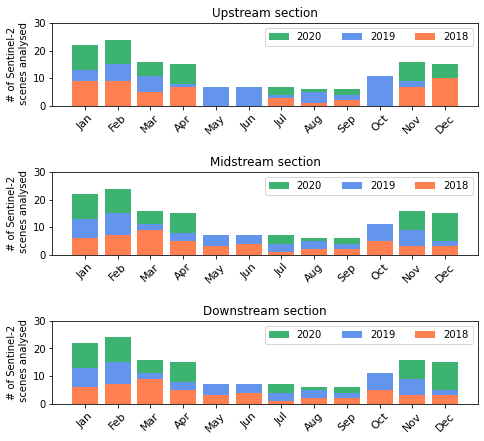

In [ ]:
# create a list with the amount of available images for 2018 upstream area
counters_1_2018 = {'Jan': 0, 'Feb': 0, 'Mar': 0, 'Apr': 0, 'May': 0, 'Jun': 0, 'Jul': 0, 'Aug': 0, 'Sep': 0, 'Oct': 0, 'Nov': 0, 'Dec': 0}

for t in date_list_sampled_1_2018:
    month = datetime.strptime(t, "%m/%d/%Y").strftime('%b')
    if month in counters_1_2018:
        counters_1_2018[month] += 1
    else:
        counters_1_2018[month] = 1

# create a list with the amount of available images for 2018 midsteam area
counters_2_2018 = {'Jan': 0, 'Feb': 0, 'Mar': 0, 'Apr': 0, 'May': 0, 'Jun': 0, 'Jul': 0, 'Aug': 0, 'Sep': 0, 'Oct': 0, 'Nov': 0, 'Dec': 0}

for t in date_list_sampled_2_2018:
    month = datetime.strptime(t, "%m/%d/%Y").strftime('%b')
    if month in counters_2_2018:
        counters_2_2018[month] += 1
    else:
        counters_2_2018[month] = 1

# create a list with the amount of available images for 2018 downstream area
counters_3_2018 = {'Jan': 0, 'Feb': 0, 'Mar': 0, 'Apr': 0, 'May': 0, 'Jun': 0, 'Jul': 0, 'Aug': 0, 'Sep': 0, 'Oct': 0, 'Nov': 0, 'Dec': 0}
for t in date_list_sampled_3_2018:
    month = datetime.strptime(t, "%m/%d/%Y").strftime('%b')
    if month in counters_3_2018:
        counters_3_2018[month] += 1
    else:
        counters_3_2018[month] = 1

# create a list with the amount of available images for 2019 upstream area
counters_1_2019 = {'Jan': 0, 'Feb': 0, 'Mar': 0, 'Apr': 0, 'May': 0, 'Jun': 0, 'Jul': 0, 'Aug': 0, 'Sep': 0, 'Oct': 0, 'Nov': 0, 'Dec': 0}
for t in date_list_sampled_1_2019:
    month = datetime.strptime(t, "%m/%d/%Y").strftime('%b')
    if month in counters_1_2019:
        counters_1_2019[month] += 1
    else:
        counters_1_2019[month] = 1

# create a list with the amount of available images for 2019 midsteam area
counters_2_2019 = {'Jan': 0, 'Feb': 0, 'Mar': 0, 'Apr': 0, 'May': 0, 'Jun': 0, 'Jul': 0, 'Aug': 0, 'Sep': 0, 'Oct': 0, 'Nov': 0, 'Dec': 0}
for t in date_list_sampled_2_2019:
    month = datetime.strptime(t, "%m/%d/%Y").strftime('%b')
    if month in counters_2_2019:
        counters_2_2019[month] += 1
    else:
        counters_2_2019[month] = 1

# create a list with the amount of available images for 2019 downstream area
counters_3_2019 = {'Jan': 0, 'Feb': 0, 'Mar': 0, 'Apr': 0, 'May': 0, 'Jun': 0, 'Jul': 0, 'Aug': 0, 'Sep': 0, 'Oct': 0, 'Nov': 0, 'Dec': 0}

for t in date_list_sampled_3_2019:
    month = datetime.strptime(t, "%m/%d/%Y").strftime('%b')
    if month in counters_3_2019:
        counters_3_2019[month] += 1
    else:
        counters_3_2019[month] = 1

# create a list with the amount of available images for 2020 upstream area
counters_1_2020 = {'Jan': 0, 'Feb': 0, 'Mar': 0, 'Apr': 0, 'May': 0, 'Jun': 0, 'Jul': 0, 'Aug': 0, 'Sep': 0, 'Oct': 0, 'Nov': 0, 'Dec': 0}

for t in date_list_sampled_1_2020:
    month = datetime.strptime(t, "%m/%d/%Y").strftime('%b')
    if month in counters_1_2020:
        counters_1_2020[month] += 1
    else:
        counters_1_2020[month] = 1

# create a list with the amount of available images for 2020 midsteam area
counters_2_2020 = {'Jan': 0, 'Feb': 0, 'Mar': 0, 'Apr': 0, 'May': 0, 'Jun': 0, 'Jul': 0, 'Aug': 0, 'Sep': 0, 'Oct': 0, 'Nov': 0, 'Dec': 0}

for t in date_list_sampled_2_2020:
    month = datetime.strptime(t, "%m/%d/%Y").strftime('%b')
    if month in counters_2_2020:
        counters_2_2020[month] += 1
    else:
        counters_2_2020[month] = 1

# create a list with the amount of available images for 2020 downstream area
counters_3_2020 = {'Jan': 0, 'Feb': 0, 'Mar': 0, 'Apr': 0, 'May': 0, 'Jun': 0, 'Jul': 0, 'Aug': 0, 'Sep': 0, 'Oct': 0, 'Nov': 0, 'Dec': 0}

for t in date_list_sampled_3_2020:
    month = datetime.strptime(t, "%m/%d/%Y").strftime('%b')
    if month in counters_3_2020:
        counters_3_2020[month] += 1
    else:
        counters_3_2020[month] = 1

# settings for image count visualization 
my_colors = [ "grey", "gainsboro"]
shift = pd.to_timedelta('1D')
fig, axis = plt.subplots(3,2,figsize=(16,7))

# upstream area image count
axis[0,0].bar(range(len(counters_1_2018)), np.array(list(counters_1_2018.values())) + np.array(list(counters_1_2019.values())) + np.array(list(counters_1_2020.values())), align='center', color = 'mediumseagreen')
axis[0,0].bar(range(len(counters_1_2019)), np.array(list(counters_1_2018.values())) + np.array(list(counters_1_2019.values())) , align='center', color = 'cornflowerblue')
axis[0,0].bar(range(len(counters_1_2020)), np.array(list(counters_1_2020.values())), align='center', color = 'coral')
axis[0,0].set_xticks(range(len(counters_1_2018)), minor=False)
axis[0,0].set_ylabel("# of Sentinel-2\n scenes analysed")
axis[0,0].set_xticks(range(len(counters_1_2018)))
axis[0,0].set_xticklabels(counters_3_2018.keys(), fontdict=None, rotation = 45, fontsize = 11)
axis[0,0].set_ylim(0,30)

# midstream area image count
axis[1,0].bar(range(len(counters_2_2020)), np.array(list(counters_2_2018.values())) + np.array(list(counters_2_2019.values())) + np.array(list(counters_2_2020.values())), align='center', color = 'mediumseagreen')
axis[1,0].bar(range(len(counters_2_2019)), np.array(list(counters_2_2018.values())) + np.array(list(counters_2_2019.values())), align='center', color = 'cornflowerblue')
axis[1,0].bar(range(len(counters_2_2018)), np.array(list(counters_2_2018.values())), align='center', color = 'coral')
axis[1,0].set_xticks(range(len(counters_2_2018)), minor=False)
axis[1,0].set_ylabel("# of Sentinel-2\n scenes analysed")
axis[1,0].set_xticks(range(len(counters_2_2018)))
axis[1,0].set_xticklabels(counters_3_2018.keys(), fontdict=None, rotation = 45, fontsize = 11)
axis[1,0].set_ylim(0,30)

# downstream area image count
axis[2,0].bar(range(len(counters_3_2018)), np.array(list(counters_3_2018.values())) + np.array(list(counters_3_2019.values())) + np.array(list(counters_3_2020.values())), align='center', color = 'mediumseagreen')
axis[2,0].bar(range(len(counters_3_2019)), np.array(list(counters_3_2018.values())) + np.array(list(counters_3_2019.values())), align='center', color = 'cornflowerblue')
axis[2,0].bar(range(len(counters_3_2020)), np.array(list(counters_3_2018.values())), align='center', color = 'coral')
axis[2,0].set_xticks(range(len(counters_3_2018)), minor=False)
axis[2,0].set_xticklabels(counters_3_2018.keys(), fontdict=None, rotation = 45, fontsize = 11)
axis[2,0].set_ylabel("# of Sentinel-2\n scenes analysed")
axis[2,0].set_ylim(0,30)

# set titles of subplots
axis[1,0].set(title='Midstream section')
axis[0,0].set(title='Upstream section')
axis[2,0].set(title='Downstream section')

# delete axis of subplots
fig.delaxes(axis[1,1])
fig.delaxes(axis[2,1])
fig.delaxes(axis[0,1])

# set legend of subplots
axis[1,0].legend(['2020', '2019', '2018'], ncol = 3)
axis[0,0].legend(['2020', '2019', '2018'], ncol = 3)
axis[2,0].legend(['2020', '2019', '2018'], ncol = 3)  

# adjust space and save subplots
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.8)
plt.savefig('./drive/My Drive/WH_article/figures/image_count.png', bbox_inches = "tight")

## 8. Visualise the processed imagery & results

In [ ]:
# for correct location of patches within visusalization below we need to index them, this is done below.
indexes = [[ 1],
           [ 0,   4,  7],
               [  3,  6], 
               [  2,  5]]

places =  [[ 1],
           [ 4,   5,  6],
               [  8,  9], 
               [ 11, 12]]


### 8.1 Plot visible spectrum at a particular date

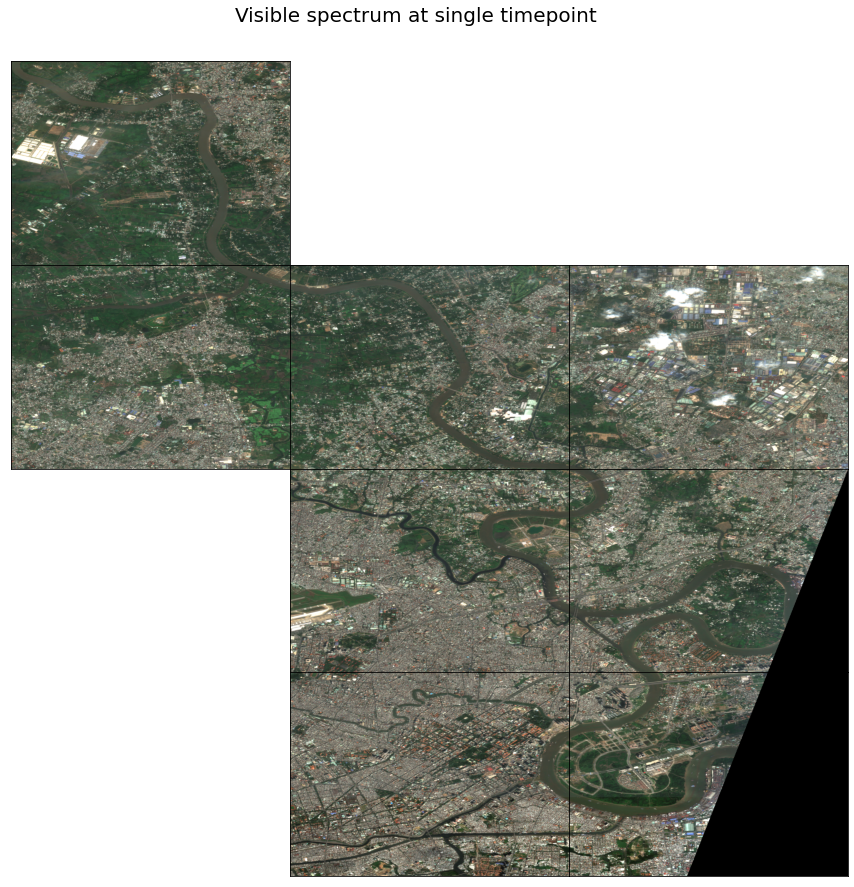

In [ ]:
path_out = './drive/My Drive/WH_article/output_folder/eopatches_sampled'
fig = plt.figure(figsize=(15, 15))
k=0

date_idx= 0

for i, (idxs, plc) in enumerate(zip(indexes, places)):
    for j, (idx, p) in enumerate(zip(idxs, plc)):
        k=k+1
        eopatch = EOPatch.load(f'{path_out}/eopatch_{idx}', lazy_loading=True)
        ax = plt.subplot(4, 3, p)
        plt.imshow(np.clip(eopatch.data['BANDS'][date_idx][..., [2, 1, 0]] * 3.5, 0, 1))
        plt.xticks([])
        plt.yticks([])
        ax.set_aspect("auto")
        del eopatch
        
fig.suptitle('Visible spectrum at single timepoint', y=0.93, size=20)
plt.savefig('Visible spectrum at single timepoint.jpg') 
fig.subplots_adjust(wspace=0, hspace=0)



### 8.2 Take a closer look at a patch (classified Water Hyacinth)

date of imagery:  2018-01-01 03:26:14+00:00


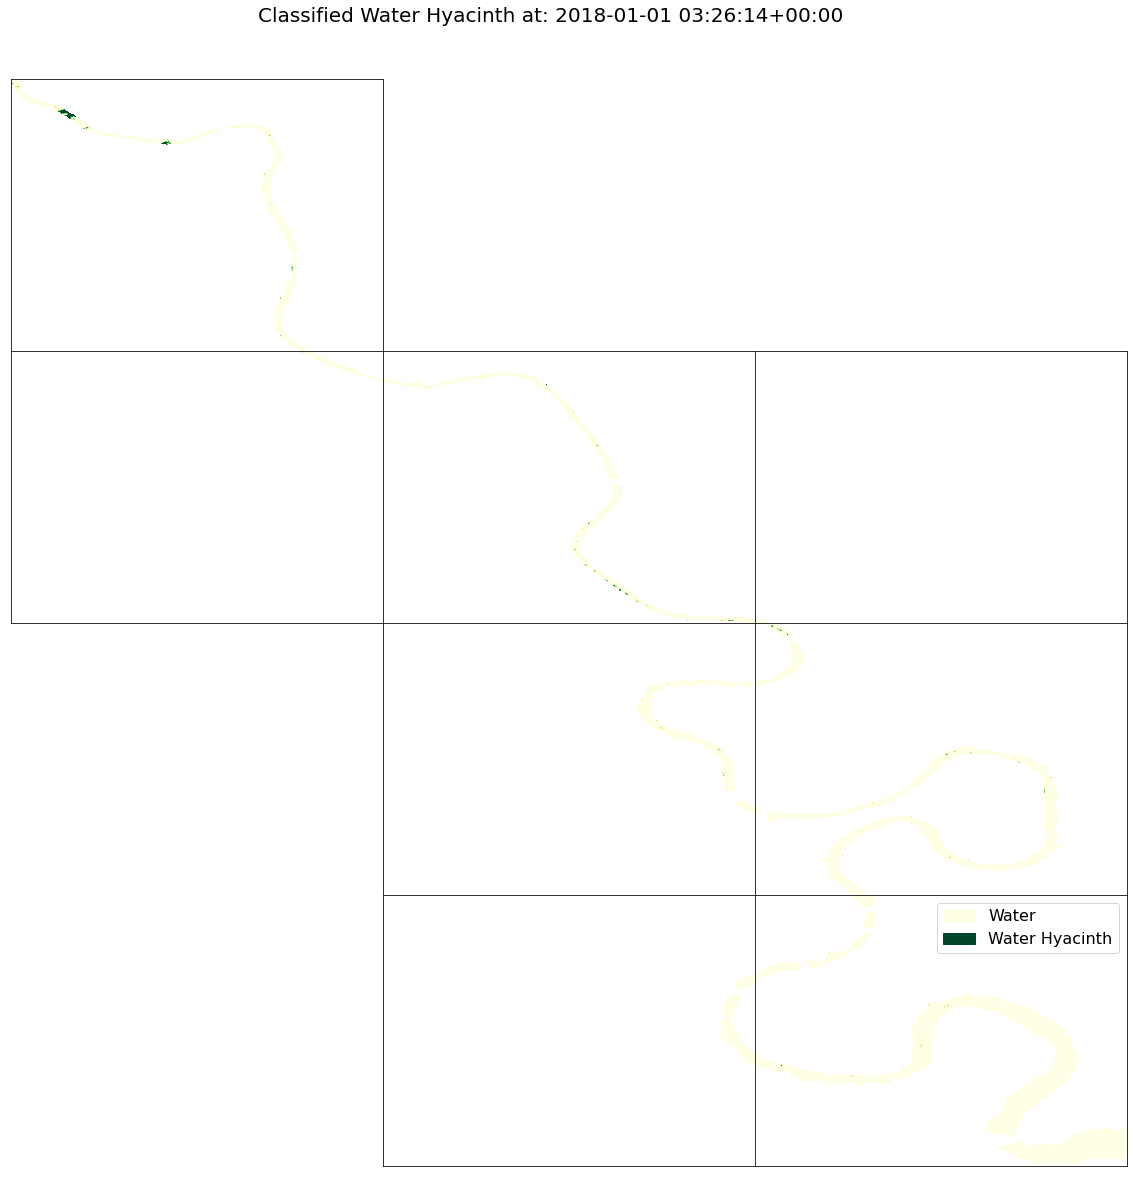

In [ ]:

path_out = './drive/My Drive/WH_article/output_folder/eopatches_sampled'

fig = plt.figure(figsize=(20, 20))
date_idx= 0
area = []

for i,  (idxs, plc) in enumerate(zip(indexes, places)):
    for j, (idx, p) in enumerate(zip(idxs, plc)):
        k=k+1
        eopatch = EOPatch.load(f'{path_out}/eopatch_{idx}', lazy_loading=True)
        ax = plt.subplot(4, 3, p)
        #mask = eopatch.mask['IS_VALID'][date_idx].astype(bool)
        mask1 = eopatch.mask_timeless['NOMINAL_WATER'].astype(bool) # mask of valid pixels
        cmi = eopatch.data['CMI'][date_idx]
        #cmi[~mask] = np.nan
        cmi[~mask1] = np.nan
        area = (np.count_nonzero(cmi == 1)) / 100
        date = eopatch.timestamp[date_idx]
        im = plt.imshow(cmi.squeeze(), cmap=plt.get_cmap('YlGn'))
        plt.xticks([])
        plt.yticks([])
        ax.set_aspect("auto")
        EoPatch_0 = ExportToTiff(feature=(FeatureType.DATA, 'CMI'),
                         folder="./drive/My Drive/WH_article/output_folder",
                         crs=CRS.UTM_48N)
        EoPatch_0.execute(eopatch, filename="s2_" + str(idx) + "}.tif")
        del eopatch


fig.subplots_adjust(wspace=0, hspace=0)
fig.suptitle('Classified Water Hyacinth at: ' + str(date), y=0.93, size=20)
print('date of imagery: ', date)
cmap=plt.get_cmap('YlGn')
my_colors = {
    'Water' : 1,
    'Water Hyacinth' : 2.0,
    }

patches = [mpatches.Patch(color=cmap(v), label=k) for k,v in my_colors.items()]

plt.legend(handles=patches, prop={'size': 16})
plt.show()

### 8.3 Plot results Water Hyacinth classification

In [ ]:
# create list with mean values for river_total, river_upstream, river_midstream and river_downstream
path_out = './drive/My Drive/WH_article/output_folder/eopatches_sampled'

# loop though all patches, lazy_load them, remove NaN's 
results = []
for i in range(7):
  eopatch = EOPatch.load(f'{path_out}/eopatch_{i}', lazy_loading=True)
  mask = eopatch.mask['IS_VALID'].astype(bool)
  mask1 = eopatch.mask_timeless['NOMINAL_WATER'].astype(bool)

  whc = eopatch.data['WHC']
  mask1 = np.broadcast_to(mask1, whc.shape)
  whc[~mask] = np.nan
  whc[~mask1] = np.nan
  time = np.array(eopatch.timestamp)
  t, w, h, _ = whc.shape

  # Calculate means, remove NaN's from means
  savi_mean_clean = (np.count_nonzero(whc.reshape(t, w * h).squeeze() ==2, axis=1)) /100
  time_clean = time[~np.isnan(savi_mean_clean)]
  savi_mean_clean = savi_mean_clean[~np.isnan(savi_mean_clean)]
  results.append(savi_mean_clean)



# Using naive method 
res = list()
for j in range(0, len(results[0])): 
    tmp = 0
    for i in range(0, len(results)): 
        tmp = tmp + results[i][j] 
    res.append(tmp) 
data = res, time_clean

# Creating pandas dataframe from numpy array
df4 = pd.DataFrame(data)
df4_transposed = df4.transpose()
df4_transposed_time = df4_transposed.iloc[:, 1]
df4_transposed_time = pd.to_datetime(df4_transposed_time).dt.date
datetime_series = pd.to_datetime(df4_transposed_time)

# create datetime index passing the datetime series
datetime_index = pd.DatetimeIndex(datetime_series.values)
df5=df4_transposed.set_index(datetime_index)

# we don't need the column anymore
df5.drop(1,axis=1,inplace=True)
df5 = df5[0]
df6 = pd.to_numeric(df5, errors='coerce')
df6_0 = df6
df7 = df6.resample('M').mean()
boxplot_3 = df7
mean = df7.interpolate()

path_out = './drive/My Drive/WH_article/output_folder/eopatches_sampled'
results = []
for i in (2,5):
  eopatch = EOPatch.load(f'{path_out}/eopatch_{i}', lazy_loading=True)
  mask = eopatch.mask['IS_VALID'].astype(bool)
  mask1 = eopatch.mask_timeless['NOMINAL_WATER'].astype(bool)

  whc = eopatch.data['WHC']
  mask1 = np.broadcast_to(mask1, whc.shape)
  whc[~mask] = np.nan
  whc[~mask1] = np.nan
  time = np.array(eopatch.timestamp)
  t, w, h, _ = whc.shape
  # Calculate means, remove NaN's from means
  savi_mean_clean = (np.count_nonzero(whc.reshape(t, w * h).squeeze() ==2, axis=1)) /100
  time_clean = time[~np.isnan(savi_mean_clean)]
  savi_mean_clean = savi_mean_clean[~np.isnan(savi_mean_clean)]
  results.append(savi_mean_clean)



# Using naive method 
res = list()
for j in range(0, len(results[0])): 
    tmp = 0
    for i in range(0, len(results)): 
        tmp = tmp + results[i][j] 
    res.append(tmp) 
data = res, time_clean

# Creating pandas dataframe from numpy array
df4 = pd.DataFrame(data)
df4_transposed = df4.transpose()
df4_transposed_time = df4_transposed.iloc[:, 1]
df4_transposed_time = pd.to_datetime(df4_transposed_time).dt.date
datetime_series = pd.to_datetime(df4_transposed_time)

# create datetime index passing the datetime series
datetime_index = pd.DatetimeIndex(datetime_series.values)
df5=df4_transposed.set_index(datetime_index)

# we don't need the column anymore
df5.drop(1,axis=1,inplace=True)
df5 = df5[0]
df6 = pd.to_numeric(df5, errors='coerce')
df6_3 = df6
df7 = df6.resample('M').mean()
boxplot_3 = df7
mean_3 = df7.interpolate()

path_out = './drive/My Drive/WH_article/output_folder/eopatches_sampled'
results = []
for i in (1, 0, 4):
  eopatch = EOPatch.load(f'{path_out}/eopatch_{i}', lazy_loading=True)
  mask = eopatch.mask['IS_VALID'].astype(bool)
  mask1 = eopatch.mask_timeless['NOMINAL_WATER'].astype(bool)

  whc = eopatch.data['WHC']
  mask1 = np.broadcast_to(mask1, whc.shape)
  whc[~mask] = np.nan
  whc[~mask1] = np.nan
  time = np.array(eopatch.timestamp)
  t, w, h, _ = whc.shape
  # Calculate means, remove NaN's from means
  savi_mean_clean = (np.count_nonzero(whc.reshape(t, w * h).squeeze() ==2, axis=1)) /100
  time_clean = time[~np.isnan(savi_mean_clean)]
  savi_mean_clean = savi_mean_clean[~np.isnan(savi_mean_clean)]
  results.append(savi_mean_clean)



# Using naive method 
res = list()
for j in range(0, len(results[0])): 
    tmp = 0
    for i in range(0, len(results)): 
        tmp = tmp + results[i][j] 
    res.append(tmp) 
data = res, time_clean

# Creating pandas dataframe from numpy array
df4 = pd.DataFrame(data)
df4_transposed = df4.transpose()
df4_transposed_time = df4_transposed.iloc[:, 1]
df4_transposed_time = pd.to_datetime(df4_transposed_time).dt.date
datetime_series = pd.to_datetime(df4_transposed_time)

# create datetime index passing the datetime series
datetime_index = pd.DatetimeIndex(datetime_series.values)
df5=df4_transposed.set_index(datetime_index)

# we don't need the column anymore
df5.drop(1,axis=1,inplace=True)
df5 = df5[0]
df6 = pd.to_numeric(df5, errors='coerce')
df6_1 = df6
df7 = df6.resample('M').mean()
boxplot_3 = df7
mean_1 = df7.interpolate()

path_out = './drive/My Drive/WH_article/output_folder/eopatches_sampled'
results = []
for i in (7, 3, 6):
  eopatch = EOPatch.load(f'{path_out}/eopatch_{i}', lazy_loading=True)
  mask = eopatch.mask['IS_VALID'].astype(bool)
  mask1 = eopatch.mask_timeless['NOMINAL_WATER'].astype(bool)

  whc = eopatch.data['WHC']
  mask1 = np.broadcast_to(mask1, whc.shape)
  whc[~mask] = np.nan
  whc[~mask1] = np.nan
  time = np.array(eopatch.timestamp)
  t, w, h, _ = whc.shape
  # Calculate means, remove NaN's from means
  savi_mean_clean = (np.count_nonzero(whc.reshape(t, w * h).squeeze() ==2, axis=1)) /100
  time_clean = time[~np.isnan(savi_mean_clean)]
  savi_mean_clean = savi_mean_clean[~np.isnan(savi_mean_clean)]
  results.append(savi_mean_clean)



# Using naive method 
res = list()
for j in range(0, len(results[0])): 
    tmp = 0
    for i in range(0, len(results)): 
        tmp = tmp + results[i][j] 
    res.append(tmp) 
data = res, time_clean

# Creating pandas dataframe from numpy array
df4 = pd.DataFrame(data)
df4_transposed = df4.transpose()
df4_transposed_time = df4_transposed.iloc[:, 1]
df4_transposed_time = pd.to_datetime(df4_transposed_time).dt.date
datetime_series = pd.to_datetime(df4_transposed_time)

# create datetime index passing the datetime series
datetime_index = pd.DatetimeIndex(datetime_series.values)
df5=df4_transposed.set_index(datetime_index)

# we don't need the column anymore
df5.drop(1,axis=1,inplace=True)
df5 = df5[0]
df6 = pd.to_numeric(df5, errors='coerce')
df6_2 = df6
df7 = df6.resample('M').mean()
boxplot_3 = df7
mean_2 = df7.interpolate()

In [ ]:
# create csv for river_total, river_upstream, river_midstream and river_downstream
df6_0.to_csv('./drive/My Drive/WH_article/output_folder/date_list.csv')
df7 = df6_0.resample('M').mean()
boxplot_0 = df7
mean = df7.interpolate()
df6_1.to_csv('./drive/My Drive/WH_article/output_folder/date_list_upstream.csv')
df7 = df6_1.resample('M').mean()
boxplot_1 = df7
mean_1 = df7.interpolate()
df6_2.to_csv('./drive/My Drive/WH_article/output_folder/date_list_midstream.csv')
df7 = df6_2.resample('M').mean()
boxplot_2 = df7
mean_2 = df7.interpolate()
df6_3.to_csv('./drive/My Drive/WH_article/output_folder/date_list_downstream.csv')
df7 = df6_3.resample('M').mean()
boxplot_3 = df7
mean_3 = df7.interpolate()

In [ ]:
df = pd.DataFrame({'date':mean.index, 'Classified \n wh [ha]':mean.values})

In [ ]:
# select march until december to be able to compare results with in_situ_measurements for each section
mean_3_2018 = mean_3[2:12]
mean_1_2018 = mean_1[2:12]
mean_2_2018 = mean_2[2:12]
mean_2018 = mean[2:12]
mean_2018 = mean_2018.interpolate()
mean_1_2018 = mean_1_2018.interpolate()

# read and alter in_situ_measurements.xlsx
sheets = pd.read_excel('./drive/My Drive/WH_article/input_data/In_situ_measurements.xlsx', sheet_name=['Sampling'])
df = pd.concat(sheets[frame] for frame in sheets.keys())
datetime_series = pd.to_datetime(df['Date'])
datetime_index = pd.DatetimeIndex(datetime_series.values)
df2=df.set_index(datetime_index)

# we don't need the column anymore
df2.drop('Date',axis=1,inplace=True)
df3 = df2['M_plast \n[kg]']
df2 = df2['M_org \n[kg]']
in_situ = df2.resample('M').mean().interpolate()
in_situ_plast = df3.resample('M').mean()

In [ ]:
# calculate percentages of water hyacinth coverage for river_total, river_upstream, river_midstream and river_downstream
mean_test = (mean / 1300) * 100
mean_test_1 = (mean_1 / 383) * 100
mean_test_2 = (mean_2 / 434) * 100
mean_test_3 = (mean_3 / 582) * 100

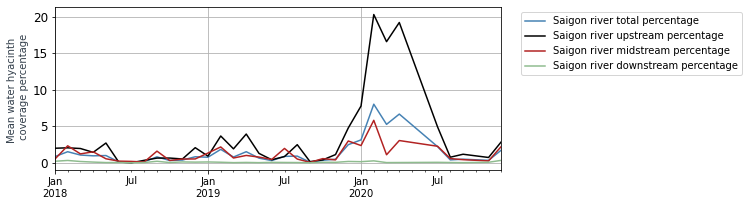

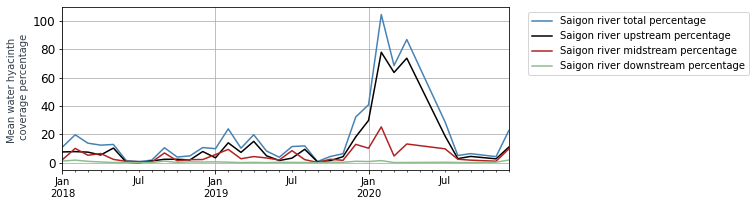

In [ ]:
# set colors for water hyacinth
mycolors2 = ['black']
mycolors3 = ['firebrick']
mycolors4 = ['darkseagreen']
mycolors5 = ['steelblue']

# plot the percentage of water hyacinth's for river_total, river_upstream, river_midstream and river_downstream
mean_test.plot(color = mycolors5, figsize = (8,3))
mean_test_1.plot(color = mycolors2, figsize = (8,3))
mean_test_2.plot(color = mycolors3, figsize = (8,3))
mean_test_3.plot(color = mycolors4, figsize = (8,3))

# set legend and other labels
plt.legend(['Saigon river total percentage', 'Saigon river upstream percentage', 'Saigon river midstream percentage', 
            'Saigon river downstream percentage'], fontsize = 10, bbox_to_anchor=(1.55, 1))
plt.yticks(fontsize = 12)
plt.ylabel('Mean water hyacinth \n coverage percentage', color = '#333F4B', fontsize = 10)
plt.xlabel('')
plt.grid()

# plot and save figure
plt.savefig('./drive/My Drive/WH_article/figures/waterhyacinth_concentrations.png', bbox_inches = "tight")
plt.show()

# plot the concentration of water hyacinth's for river_total, river_upstream, river_midstream and river_downstream
mean.plot(color = mycolors5, figsize = (8,3))
mean_1.plot(color = mycolors2, figsize = (8,3))
mean_2.plot(color = mycolors3, figsize = (8,3))
mean_3.plot(color = mycolors4, figsize = (8,3))

# set legend and other labels
plt.legend(['Saigon river total percentage', 'Saigon river upstream percentage', 'Saigon river midstream percentage', 
            'Saigon river downstream percentage'], fontsize = 10, bbox_to_anchor=(1.55, 1))
plt.yticks(fontsize = 12)
plt.ylabel('Mean water hyacinth \n coverage percentage', color = '#333F4B', fontsize = 10)
plt.xlabel('')
plt.grid()

# plot and save figure
plt.savefig('./drive/My Drive/WH_article/figures/waterhyacinth_concentrations.png', bbox_inches = "tight")

plt.show()


Scipy computed Pearson r: 0.5886050390732805 and p-value: 0.07343337100365975
Pandas computed Pearson r: 0.5886050390732808


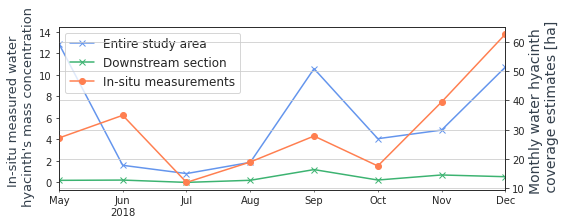

In [ ]:
# figure settings 
fig,ax = plt.subplots()
ax2=ax.twinx()

# plot the percentage of water hyacinth's for river_total, river_downstream and in_situ_measurements
mean_2018.plot(figsize = (8,3), ax=ax, marker = 'x', color = 'cornflowerblue', label = "Entire study area")
mean_3_2018.plot(figsize = (8,3), ax=ax, marker = 'x', color =  'mediumseagreen', label = "Downstream section")
in_situ[2:12].plot(figsize = (8,3), ax=ax2, marker = 'o', color =  'coral', label = "In-situ measurements")
ax2.set_ylabel('Monthly water hyacinth \n coverage estimates [ha]', color = '#333F4B', fontsize = 14)
ax.set_ylabel("In-situ measured water \n hyacinth's mass concentration", color = '#333F4B', fontsize = 13)

# set labels and lines for plot
lines_1, labels_1 = ax.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
lines = lines_1 + lines_2
labels = labels_1 + labels_2

# set legend
ax.legend(lines, labels, fontsize = 12, loc = 'upper left')
plt.xlabel('')

# compute pearson correlation between in_situ_measurements and downstream section
r, p = stats.pearsonr(in_situ.dropna(), mean_3_2018.dropna())
print(f"Scipy computed Pearson r: {r} and p-value: {p}")
overall_pearson_r = in_situ.corr(mean_3_2018)
print(f"Pandas computed Pearson r: {overall_pearson_r}")

# plot and save figure
plt.grid()
plt.savefig('./drive/My Drive/WH_article/figures/waterhyacinth_concentrations.png', bbox_inches = "tight")

plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

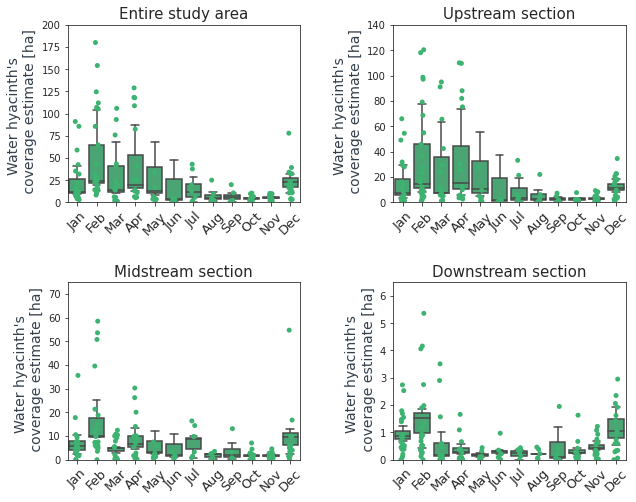

In [ ]:
# figure settings
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,8))
    
# boxplot and stripplot for the upstream section 
sns.boxplot(mean_1.index.month, mean_1, fliersize=0, ax=axes[0,1], color = 'mediumseagreen') 
sns.stripplot(df6_1.index.month, df6_1, ax=axes[0,1], color = 'mediumseagreen',  linewidth=0)
axes[0,1].set_ylabel("Water hyacinth's \n coverage estimate [ha]", color = '#333F4B', fontsize = 14)
axes[0,1].set_xlabel('', fontsize = 16)
axes[0,1].set_ylim(0,140)
axes[0,1].set_title('Upstream section', fontsize = 15)

# boxplot and stripplot for the entire study area
sns.boxplot(mean.index.month, mean, fliersize=0, ax = axes[0,0], color = 'mediumseagreen') 
sns.stripplot(df6_0.index.month, df6_0, ax=axes[0,0], color = 'mediumseagreen',  linewidth=0)
axes[0,0].set_ylabel("Water hyacinth's \n coverage estimate [ha]", color = '#333F4B', fontsize = 14)
axes[0,0].set_xlabel('', fontsize = 16)
axes[0,0].set_ylim(0,200)
axes[0,0].set_title('Entire study area', fontsize = 15)

# boxplot and stripplot for the downstream section 
sns.boxplot(mean_3.index.month, mean_3, fliersize=0, ax=axes[1,1], color = 'mediumseagreen') 
sns.stripplot(df6_3.index.month, df6_3, ax=axes[1,1], color = 'mediumseagreen',  linewidth=0)
plt.ylabel("Water hyacinth's \n coverage estimate [ha]", color = '#333F4B', fontsize = 14)
plt.xlabel('', fontsize = 16)
axes[1,1].set_ylim(0,6.5)
axes[1,1].set_title('Downstream section', fontsize = 15)

# boxplot and stripplot for the midsteam section 
sns.boxplot(mean_2.index.month, mean_2, fliersize=0, ax = axes[1,0], color = 'mediumseagreen') 
sns.stripplot(df6_2.index.month, df6_2, ax=axes[1,0], color = 'mediumseagreen',  linewidth=0)
axes[1,0].set_ylabel("Water hyacinth's \n coverage estimate [ha]", color = '#333F4B', fontsize = 14)
axes[1,0].set_xlabel('', fontsize = 16)
axes[1,0].set_ylim(0,75)
axes[1,0].set_title('Midstream section', fontsize = 15)

# settings subplots
plt.setp(axes, xticks=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], xticklabels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
axes[0,1].tick_params(axis='x', rotation=45, labelsize = 13)
axes[0,0].tick_params(axis='x', rotation=45, labelsize = 13)
axes[1,0].tick_params(axis='x', rotation=45, labelsize = 13)
axes[1,1].tick_params(axis='x', rotation=45, labelsize = 13)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=0.45)

# plot and save figure
plt.savefig('./drive/My Drive/WH_article/figures/boxplot_waterhyacinth.png', bbox_inches = "tight")
